#### Final Project: Rick & Morty analysis

# Phase 3: Exploring Data (Laurine)

In [479]:
# imports
import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
import codecs
import numpy as np
from IPython.display import display

import seaborn as sns
sns.set()

## 1.3. Finding the “favourite words” of the Smith/Sanchez family

**Focus on characters: Rick Sanchez, Morty Smith, Beth Smith, Jerry Smith, Summer Smith**

### REPORT

What the Kaggle study found: https://www.kaggle.com/andradaolteanu/sentiment-analysis-rick-and-morty-scripts (see "most 10 words from the Smith family" plots)

#### 1st approach
- I only used the transcript database of the Kaggle study we found on Sentiment Analysis
- Pre-processing = lower case + exclude characters' name + NLTK tokenization + NLTK lemmatization + remove words with 2 letters or less

**CCL** : 
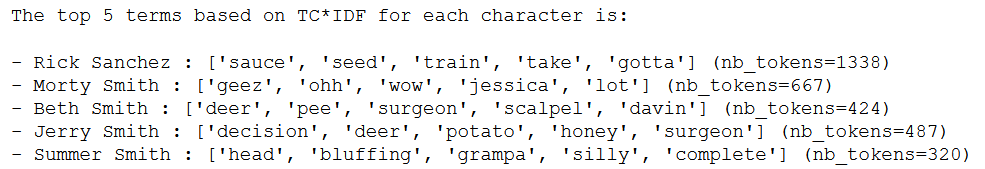

We clearly need more words, especially for Beth, Jerry and Summer! We identify the words from the first episode, when Beth is saving a shot deer.

## Generate data files (tokens)

In [2]:
# load data
df_transcripts = pd.read_csv('transcripts/RickAndMortyScripts.csv')
df_transcripts.head()

,season no.,episode no.,episode name,name,line
0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."


In [58]:
to_search = "You think supporting the family is about supporting you emotionally"
df_transcripts[df_transcripts.line.str.contains(to_search)]

,season no.,episode no.,episode name,name,line
5043,2,3,Auto Erotic Assimilation,Beth,You think supporting the family is about suppo...


In [3]:
# create a text with lines of for each character

family_list = {
    'Rick':'Rick Sanchez',
    'Morty':'Morty Smith',
    'Beth':'Beth Smith',
    'Jerry':'Jerry Smith',
    'Summer':'Summer Smith'}

dict_text = {k:"" for k in family_list.keys()}

def add_line_to_text(aRow):
    if aRow['name'] in family_list:
        dict_text[aRow['name']] += (' '+str(aRow['line']))

_ = df_transcripts.apply(add_line_to_text, axis=1)

In [149]:
rev_family_list = {v:k for k,v in family_list.items()}

In [4]:
from os import listdir
from os.path import isfile, join

import nltk
from nltk.tokenize import WordPunctTokenizer

In [5]:
# apply the tokenization process

pages_path = 'character_words'
all_files = [f for f in listdir(pages_path) if isfile(join(pages_path, f))]

In [6]:
# get the stopwords list in given language
from gensim.parsing.preprocessing import STOPWORDS
stopwords = STOPWORDS
# tokenization factory
tk = WordPunctTokenizer()
# lemmatization factory
lm = nltk.WordNetLemmatizer()

# for each character
for aFile in all_files:
    # Read the file containing the character's page description.
    character_page = open(pages_path+'/'+aFile, encoding="utf-8").read() 
    # Set everything to lower case.
    character_page = character_page.lower()
    # Exclude characters names, BEFORE tokenisation
    for aCharacterName in family_list.keys():
        character_page = character_page.replace(aCharacterName.lower(),'')
    # Tokenize your text
    character_page = tk.tokenize(character_page)
    # Exclude punctuation and stop words
    character_page = [aToken for aToken in character_page if aToken.isalnum() and aToken not in stopwords]
    # Lemmatize words
    character_page = [ lm.lemmatize(w) for w in character_page ]
    # Remove words with less than 2 letters
    character_page = [ w for w in character_page if len(w)>2]
    # Transform list into list separated by spaces
    character_page = ''.join([str(elem)+' ' for elem in character_page])
    # Save your output for future use
    # f = codecs.open('character_words_tokens/'+aFile, "w+", "utf-8")
    # f.write(character_page)
    # f.close()

## Overview of the whole family words

In [7]:
from nltk.corpus import PlaintextCorpusReader

In [8]:
# create NLTK objects: Corpus and Text
corpus_root = 'character_words_tokens'
familyCorpus = PlaintextCorpusReader(corpus_root, all_files)
familyText = nltk.Text(familyCorpus.words())

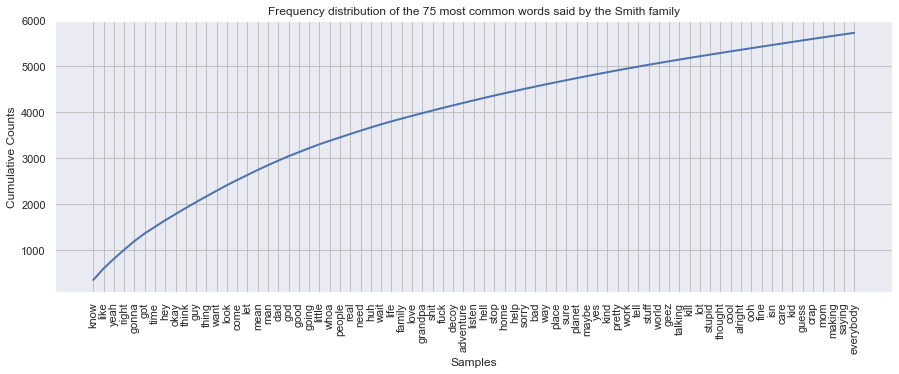

In [181]:
# get the freq distribution of tokens
fdist_family = nltk.FreqDist(familyText)
nb_words = 75
fdist_family.most_common(nb_words)
plt.figure(figsize=(15,5))
plt.title(f'Frequency distribution of the {nb_words} most common words said by the Smith family')
fdist_family.plot(nb_words, cumulative=True)
plt.show()

# NLTK stats and computations

In [251]:
def dic_reverse_sort(aDict, rev=True):
    return dict(sorted(aDict.items(), reverse=rev, key=lambda x:x[1]))

In [100]:
familyText.similar('family')

dad know life build god important old dunno day far dressed


In [82]:
familyText.common_contexts(['family','important'])
familyText.common_contexts(['family','life'])

think_love
time_friend


In [89]:
# study each character's words
char_documents = {aCharacter:nltk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}
char_documents

{'Rick Sanchez': <Text: gotta come jus gotta come got surprise come...>,
 'Morty Smith': <Text: going middle night talking tugging hard yeah great...>,
 'Beth Smith': <Text: getting sick told practice kiss living room pillow...>,
 'Jerry Smith': <Text: new episode singing tonight guy think gonna best...>,
 'Summer Smith': <Text: god head food going puke maybe night grandpa...>}

In [109]:
# who is the most talkative
most_talkative = dic_reverse_sort({k:len(t)/len(familyText) for k,t in char_documents.items()})
most_talkative

{'Rick Sanchez': 0.5007924827351976,
 'Morty Smith': 0.21895165855315296,
 'Jerry Smith': 0.12702366127023662,
 'Summer Smith': 0.07902184988112759,
 'Beth Smith': 0.0742103475602853}

In [176]:
nb_lines = dic_reverse_sort({k:len(df_transcripts[df_transcripts.name == rev_family_list[k]]) for k,t in char_documents.items()})
nb_lines

{'Rick Sanchez': 1456,
 'Morty Smith': 1020,
 'Jerry Smith': 490,
 'Summer Smith': 381,
 'Beth Smith': 353}

In [129]:
char_colors = {'Rick Sanchez':'#95e4f0', 'Morty Smith':'#f7ecb0','Jerry Smith':'#6fde8b','Summer Smith':'#e895de','Beth Smith':'#e8a2a2'}

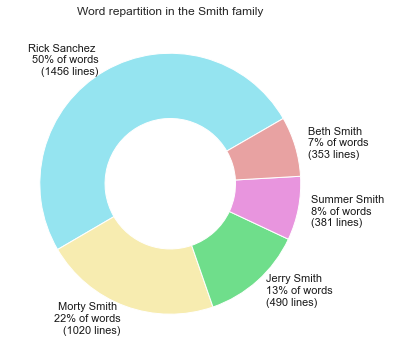

In [180]:
# plot most talkative : pie chart
plt.figure(figsize=(6,6))
font_color = 'k'
plt.pie(most_talkative.values(), 
           labels=['{} \n{}% of words\n({} lines)'.format(k,round(100*v),nb_lines[k]) for k,v in most_talkative.items()], 
           startangle=30, 
           wedgeprops=dict(width=.5), # For donuts
           colors=[char_colors[k] for k in most_talkative.keys()],
           textprops={'color':font_color})
plt.title("Word repartition in the Smith family")
plt.show()

In [110]:
# compare lexical diversities

# functions from Natural Language Processing with Python (NLPP), Chapter 1.4
def lexical_diversity(text):
    return len(set(text)) / len(text)

print("Overall lexical diversity: ", lexical_diversity(familyText))

compare_lexical_diversity = dic_reverse_sort({k:lexical_diversity(v) for k,v in char_documents.items()})
compare_lexical_diversity

Overall lexical diversity:  0.2345182837088192


{'Summer Smith': 0.5286532951289399,
 'Beth Smith': 0.528604118993135,
 'Jerry Smith': 0.4768270944741533,
 'Morty Smith': 0.3518614270941055,
 'Rick Sanchez': 0.3227082626879168}

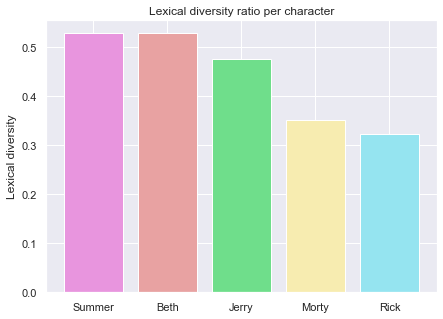

In [165]:
x = list(range(5))
plt.figure(figsize=(7,5))
plt.bar(x,compare_lexical_diversity.values(),color=[char_colors[k] for k in compare_lexical_diversity.keys()])
plt.xticks(x,[rev_family_list[k] for k in compare_lexical_diversity.keys()])
plt.title("Lexical diversity ratio per character")
plt.ylabel("Lexical diversity")
plt.show()

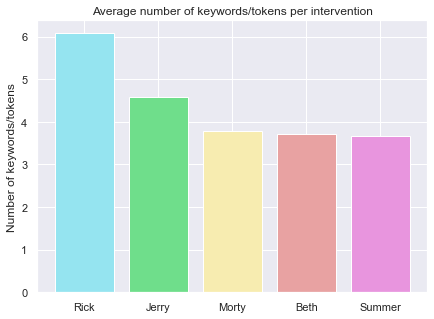

In [173]:
# tokens/nb of lines
most_talkative2 = dic_reverse_sort({k:len(t)/len(df_transcripts[df_transcripts.name == rev_family_list[k]]) for k,t in char_documents.items()})
most_talkative2

x = list(range(5))
plt.figure(figsize=(7,5))
plt.bar(x,most_talkative2.values(),color=[char_colors[k] for k in most_talkative2.keys()])
plt.xticks(x,[rev_family_list[k] for k in most_talkative2.keys()])
plt.ylabel('Number of keywords/tokens')
plt.title("Average number of keywords/tokens per intervention")

plt.show()

## The favourites words of each character from the Smith family >> TC-IDF

Why TC? Better to plot wordclouds later.

In [10]:
# get one document (of tokens) per character
char_documents = {aCharacter:nltk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}

In [11]:
# compute the TC of each character
char_fdist = {aCharacter:nltk.FreqDist(aText) for aCharacter, aText in char_documents.items()}

def getTC(t, aFdist):
    """ Get the term count of a term t in a document d whose we already computed the frequency distribution aFdist"""
    return aFdist[t]

def find_top_5_terms(aText):
    """ Find the 5 most common terms in the text """
    fdist = nltk.FreqDist(aText)
    fdist = dict(fdist.most_common(5))
    return {k:v/len(aText) for k,v in fdist.items()}

# find the top 5 terms for each character based on TC
family_top_5_terms = {aChar:find_top_5_terms(aCharText) for aChar, aCharText in char_documents.items()}

# print results
print("The top 5 terms for each character is:\n")
for aChar, aListOfTerms in family_top_5_terms.items():
    print("- {} : {}".format(aChar, list(aListOfTerms.keys())))

The top 5 terms for each character is:

- Rick Sanchez : ['know', 'gonna', 'right', 'like', 'yeah']
- Morty Smith : ['know', 'like', 'right', 'yeah', 'gonna']
- Beth Smith : ['dad', 'know', 'okay', 'like', 'want']
- Jerry Smith : ['know', 'like', 'hey', 'guy', 'okay']
- Summer Smith : ['grandpa', 'god', 'yeah', 'like', 'dad']


In [12]:
# compute the IDF for every word
def getIDF(t,D, fdist_dic):
    """ Get the inverse document frequency of a term t among the corpus D whose we give the frequency distributions fdist_dic """
    N = len(D)
    nb_texts_with_term = 1 + sum([1 if getTC(t,fdist_dic[a]) else 0 for a in list(D.keys()) ])
    return np.log10(N/nb_texts_with_term)

all_words_IDFs = {aTerm:getIDF(aTerm, char_documents, char_fdist) for aTerm in familyText}

In [13]:
# compute TC-IDF
def getTC_IDF(t,aFdist):
    """ get the TC*IDF for a term t, a document d from a corpus D (here, a dictionary of Texts) """
    return getTC(t, aFdist) * all_words_IDFs[t]

family_TC_IDF = {aChar:{aTerm:getTC_IDF(aTerm, char_fdist[aChar]) for aTerm in aText } for aChar,aText in char_documents.items() }
family_TC_IDF_sorted = {aChar:dict(sorted(aTCIDF_dic.items(), reverse=True, key=lambda x:x[1])) for aChar, aTCIDF_dic in family_TC_IDF.items()}

# print results
print("The top 5 terms based on TC*IDF for each character is:\n")
for aChar, aTC_IDF_dic in family_TC_IDF_sorted.items():
    print("- {} : {} (nb_tokens={})".format(aChar, list(aTC_IDF_dic)[:5], len(list(aTC_IDF_dic) )))

The top 5 terms based on TC*IDF for each character is:

- Rick Sanchez : ['sauce', 'number', 'bunch', 'season', 'piece'] (nb_tokens=2855)
- Morty Smith : ['ohh', 'duane', 'geez', 'ohhhh', 'bawk'] (nb_tokens=1361)
- Beth Smith : ['surgeon', 'cling', 'performing', 'surgery', 'davin'] (nb_tokens=693)
- Jerry Smith : ['apple', 'pluto', 'tru', 'award', 'potato'] (nb_tokens=1070)
- Summer Smith : ['drum', 'needful', 'bluffing', 'nancy', 'ethan'] (nb_tokens=738)


# Word clouds

In [14]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [15]:
def plot_wordcloud(chosen_element, documents_dic, TC_IDF_dic, aMaskFileName, aFigure):
    """ 
    Generate N wordclouds (based on given chosen_elements) using 
    - documents_dic {aKey:aDocument},
    - TC_IDF_dic {aKey{aWord:aScore}},
    in the matplotlib.pyplot Figure (aFigure) with a fancy mask (aMaskFileName) if wanted
    """
    if aMaskFileName != None:
        mask = np.array(Image.open(aMaskFileName))
    
    # Adjust the number of occurrences of each word based on TC-IDF
    list_to_wordcloud = []
    for aTerm in list(documents_dic[chosen_element]):
        multiplicator = round(TC_IDF_dic[chosen_element][aTerm])
        list_to_wordcloud = list_to_wordcloud + multiplicator*[aTerm]
        
    # Generate a word cloud image
    if aMaskFileName != None:
        wordcloud = WordCloud(background_color="white", mask=mask, collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        # create coloring from image
        image_colors = ImageColorGenerator(mask)
        aFigure.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        wordcloud = WordCloud(background_color="white", collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        aFigure.imshow(wordcloud, interpolation='bilinear')   
    aFigure.set_title(chosen_element, size=15)
    aFigure.axis("off")

In [16]:
# get masks for plots
url_base_masks = "masks/"
all_masks = ["rick_blue.png", "morty_yellow.png", "beth_red.png", "jerry_green.png", 'summer_pink.png']
all_masks = [ url_base_masks+aMaskFileName for aMaskFileName in all_masks ]

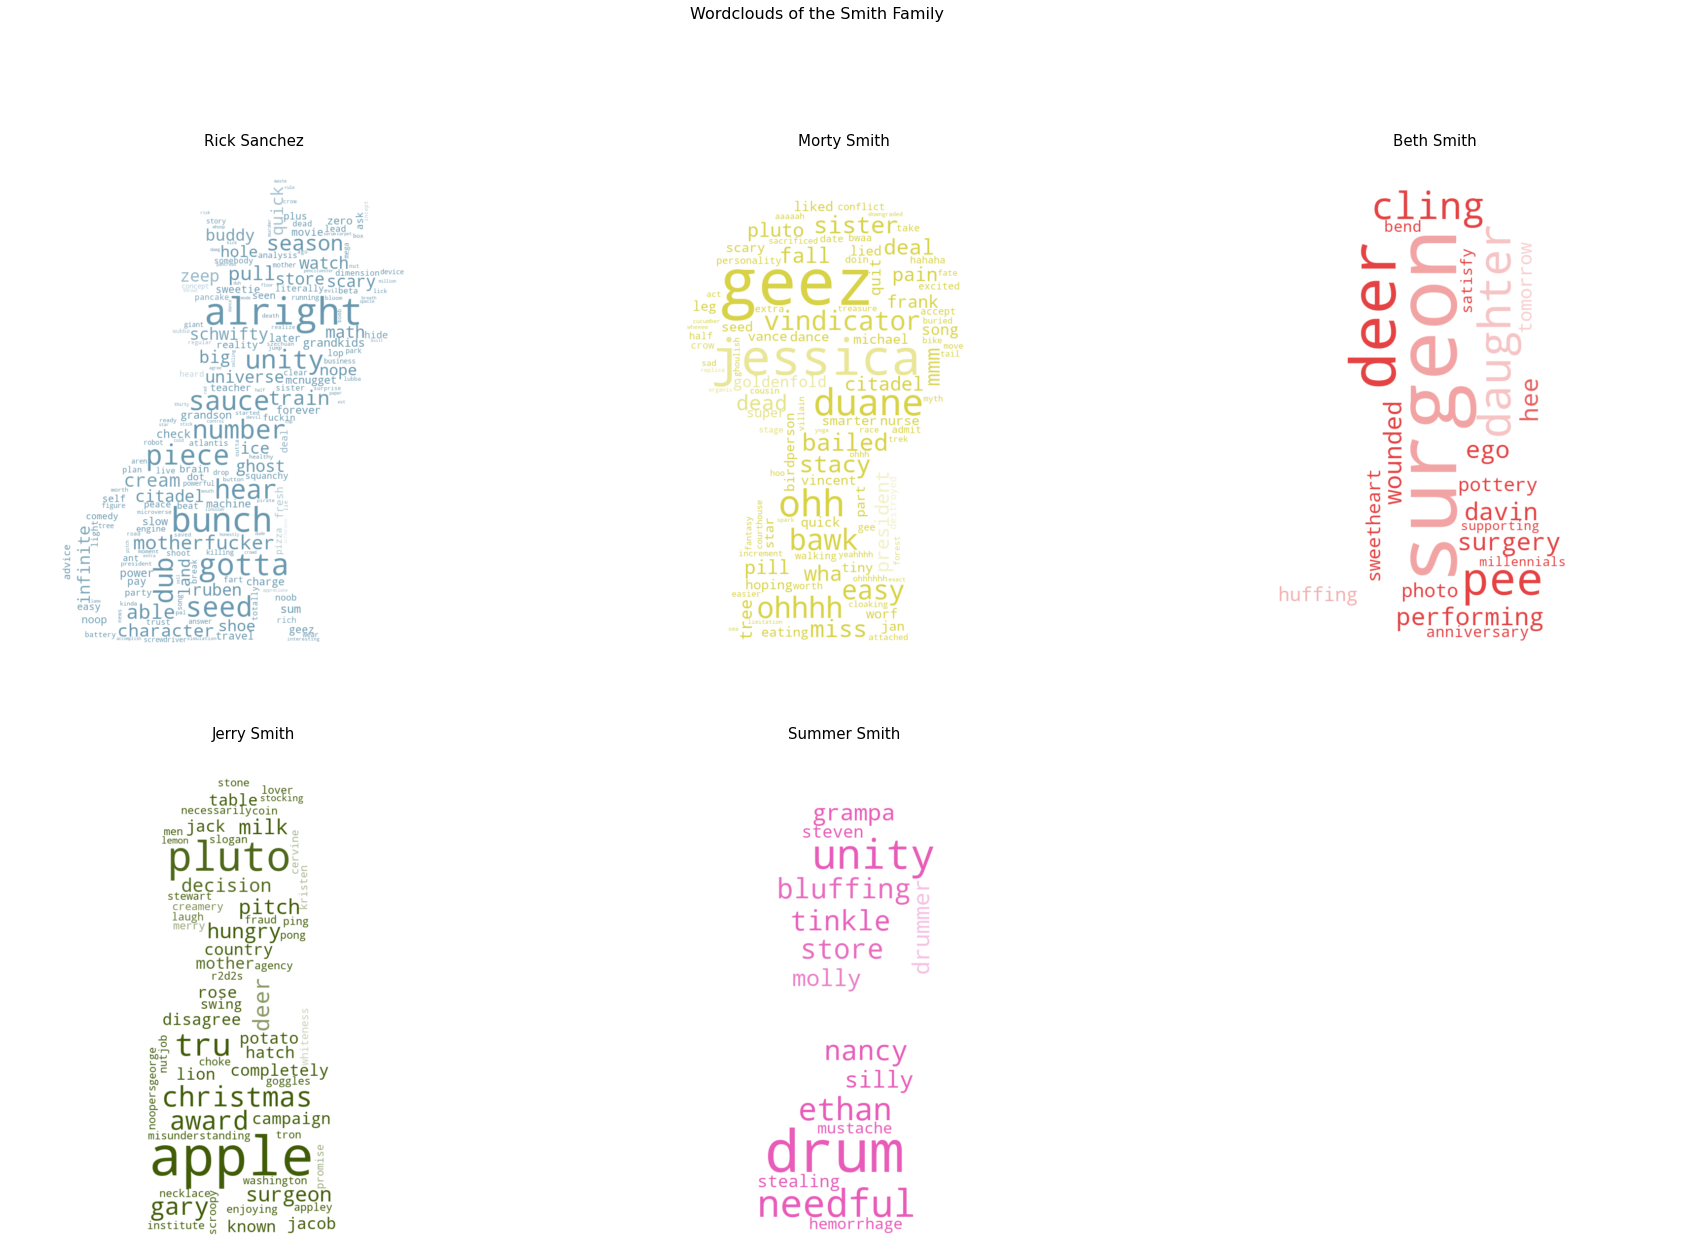

In [17]:
# plot wordclouds
fig, axes = plt.subplots(2,3,figsize=(30,20), subplot_kw={'xticks':[], 'yticks':[]})
fig.suptitle("Wordclouds of the Smith Family", fontsize=16)

for i,ax in enumerate(axes.flat):
    if i<5:
        plot_wordcloud(list(family_list.values())[i], char_documents, family_TC_IDF, all_masks[i], ax)
    else:
        ax.set_visible(False)
plt.show()

# Get bigrams

In [18]:
def get_50_most_frequent_bigrams_not_stopwords(aText, language = 'english', top_nb = 50):
    """Get  the 50 most most frequent bigrams of a text that are not stopwords. 
    By default, the text is in English"""
    # get the stopwords list in given language
    stopwords = nltk.corpus.stopwords.words(language)
    # drop stopwords from text and punctuation
    content = nltk.Text([w for w in aText if w.lower() not in stopwords and w.isalnum()])
    # get bigrams
    bigrams_list = list(nltk.bigrams(content))
    # compute frequency distribution for bigrams
    fdist_bigrams = nltk.FreqDist([a+' '+b for (a,b) in bigrams_list])
    # return 50 most common bigrams
    return fdist_bigrams.most_common(top_nb)

In [19]:
for aCharacter in family_list.values():
    print("For "+aCharacter+' : ')
    print(get_50_most_frequent_bigrams_not_stopwords(char_documents[aCharacter], top_nb=5))

For Rick Sanchez : 
[('look like', 19), ('whoa whoa', 15), ('portal gun', 10), ('yeah yeah', 10), ('ice cream', 8)]
For Morty Smith : 
[('yeah know', 8), ('know mean', 8), ('hey know', 7), ('holy crap', 5), ('know right', 5)]
For Beth Smith : 
[('holy crap', 3), ('open door', 3), ('decoy family', 3), ('way dad', 2), ('time life', 2)]
For Jerry Smith : 
[('pluto planet', 7), ('planet planet', 6), ('whoa whoa', 5), ('sleepy gary', 5), ('look like', 4)]
For Summer Smith : 
[('god god', 6), ('ooh ooh', 6), ('drum drum', 5), ('dad like', 3), ('yes yes', 3)]


# Sentiment analysis of their words: how do they interact to each other? which sentiments do they express ?

Use of NRC lexicon : https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

Steps to follow:
1. Create files with lines: a source to a target
2. Tokenize
3. Sentiment VADER method analysis for all lexicons
4. Rankings and relationships comparisons: enough tokens, reciprocity

## Compute interaction scores

To add:
- Morty to Beth: 'mom'
- Morty to Jerry: 'dad'
- Beth to Rick: 'dad'
- Summer to Jerry: 'dad'
- Summer to Beth: 'mom'

In [303]:
additional_targets_dict = {
    ('Morty','Beth'):'mom',
    ('Morty','Jerry'):'dad',
    ('Beth','Rick'): 'dad',
    ('Summer','Jerry'):'dad',
    ('Summer','Beth'):'mom'
}

In [329]:
def get_df_substract(source_char, target_char):
    """ Get the dataframe of a source character talking to a target character"""
    return_df = df_transcripts[(df_transcripts.name==source_char) & (df_transcripts.line.str.contains(target_char))]
    if (source_char,target_char) in additional_targets_dict.keys():
        additionnal_appelation = additional_targets_dict[(source_char,target_char)]
        return_df = return_df.append(df_transcripts[(df_transcripts.name==source_char) & (df_transcripts.line.str.contains(additionnal_appelation, case=False))])
    return return_df

In [332]:
df_NRC = pd.read_csv('lexicons/NRC_sentiment_lexicon.csv')
df_NRC_VAD = pd.read_csv('lexicons/NRC-VAD-Lexicon.csv')

In [333]:
def combine_lines(aDataFrame):
    result = ''
    for _, aRow in aDataFrame.iterrows():
        result += aRow.line+' '
    return result

def get_word_tokens(aTextOfLines):
    """ Lower + tokenization + remove punctuation """
    # Set to lower case
    aTextOfLines = aTextOfLines.lower()
    # Tokenize
    tokens = tk.tokenize(aTextOfLines)
    # Remove punctuation
    tokens = [aToken for aToken in tokens if aToken.isalnum()]
    # Lemmatize 
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens

def analyse_text_NRC(aText, aDF = None):
    """ Get the NRC sentments + VAD scores of a given text (aText)
    Output : dict of VAD scores / dict of sentiments scores / tokens / text """
    tokens = get_word_tokens(aText)
    
    result_sentiments_df = df_NRC[df_NRC.Word.isin(tokens)]
    result_VAD_df = df_NRC_VAD[df_NRC_VAD.Word.isin(tokens)]
    
    result_sentiments_dict = result_sentiments_df.sum().drop('Word')/len(result_sentiments_df)
    result_VAD_dict = result_VAD_df.sum().drop('Word')/len(result_VAD_df)
    result_sentiments_dict = dict(sorted(result_sentiments_dict.items(), reverse=True, key=lambda x:x[1]))
    result_VAD_dict = dict(sorted(result_VAD_dict.items(), reverse=True, key=lambda x:x[1]))
    
    return {'VAD scores':result_VAD_dict, 'sentiment scores':result_sentiments_dict, 'tokens':tokens, 'lines':aText, 'df':aDF}

def analyse_interactions_NRC(source_char, target_char):
    """ Get the NRC sentiments + VAD scores when source_char talk to target_char """
    df = get_df_substract(source_char, target_char)
    text = combine_lines(df)
    return analyse_text_NRC(text, df)

def analyse_one_char_words(source_char):
    """ Get the NRC sentiments + VAD scores for only source_char lines """
    df = df_transcripts[df_transcripts.name==source_char]
    text = combine_lines(df)
    return analyse_text_NRC(text, df)

def get_text_of(source,target=None):
    if target==None:
        df = df_transcripts[df_transcripts.name==source]
        return combine_lines(df)
    df = get_df_substract(source, target)
    return combine_lines(df)

Detail of VAD sentiments:
- valence: from NEGATIVE/DISPLEASURE to POSITIVE/PLEASURE
- arousal: from CALM/PASSIVE to EXCITED/ACTIVE
- dominance: FROM WEAK/CONTROLLED to POWERFUL/CONTROL

Detail of NRC sentiments: anger, fear, anticipation, trust, surprise, sadness, joy, or disgust

In [334]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# generate all lexicons
all_lexicons = {}
for element in ['Arousal','Dominance','Valence']:
    all_lexicons[element]= {aRow.Word:8*aRow[element]-4 for _, aRow in df_NRC_VAD[['Word',element]].iterrows()}
for element in df_NRC.drop('Word',axis=1).columns:
    all_lexicons[element] = {aRow.Word:8*aRow[element]-4 for _, aRow in df_NRC[['Word',element]].iterrows()}
all_lexicons['Valence_VADER']= SentimentIntensityAnalyzer().lexicon

### For interactions 'source', 'target'

In [335]:
# [Source, Target, Nb_tokens, Valence, Arousal, Dominance, Anger, Fear, Anticipation, Trust, Surprise, Sadness, Joy, Disgust]
# VADER METHOD
interactions_sentiment_scores = []

for aSourceChar in family_list.keys():
    print('Processing...', aSourceChar)
    for aTargetChar in family_list.keys():
        if aSourceChar != aTargetChar:
            results = analyse_interactions_NRC(aSourceChar,aTargetChar)
            nb_tokens = len(results['tokens'])
            aRow = [aSourceChar, aTargetChar, nb_tokens]
            for aSentiment, aLexicon in all_lexicons.items():
                print('   Sentiment: ', aSentiment)
                analyzer.lexicon = aLexicon
                polarity_score = analyzer.polarity_scores(results['lines'])
                aRow.append(polarity_score['compound'])
            interactions_sentiment_scores.append(aRow)

# to dataframe
df_family_interactions = pd.DataFrame(interactions_sentiment_scores,columns=['Source','Target','Nb_tokens']+list(all_lexicons.keys()))
df_family_interactions = df_family_interactions[df_family_interactions.Nb_tokens>0]

Processing... Rick
   Sentiment:  Arousal
   Sentiment:  Dominance
   Sentiment:  Valence
   Sentiment:  Positive
   Sentiment:  Negative
   Sentiment:  Anger
   Sentiment:  Anticipation
   Sentiment:  Disgust
   Sentiment:  Fear
   Sentiment:  Joy
   Sentiment:  Sadness
   Sentiment:  Surprise
   Sentiment:  Trust
   Sentiment:  Valence_VADER
   Sentiment:  Arousal
   Sentiment:  Dominance
   Sentiment:  Valence
   Sentiment:  Positive
   Sentiment:  Negative
   Sentiment:  Anger
   Sentiment:  Anticipation
   Sentiment:  Disgust
   Sentiment:  Fear
   Sentiment:  Joy
   Sentiment:  Sadness
   Sentiment:  Surprise
   Sentiment:  Trust
   Sentiment:  Valence_VADER
   Sentiment:  Arousal
   Sentiment:  Dominance
   Sentiment:  Valence
   Sentiment:  Positive
   Sentiment:  Negative
   Sentiment:  Anger
   Sentiment:  Anticipation
   Sentiment:  Disgust
   Sentiment:  Fear
   Sentiment:  Joy
   Sentiment:  Sadness
   Sentiment:  Surprise
   Sentiment:  Trust
   Sentiment:  Valence_VADER


In [505]:
df_family_interactions = pd.read_csv('family_interactions_sentiment_scores.csv')
df_family_interactions = df_family_interactions[df_family_interactions.Nb_tokens > 100]

In [506]:
df_family_interactions.drop('Nb_tokens',axis=1).sort_values(['Source','Target'])

,Source,Target,Arousal,Dominance,Valence,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust,Valence_VADER
10,Beth,Jerry,-0.9982,0.8181,0.9996,-0.9994,0.5571,-0.9996,-0.9997,-0.9998,-0.9995,-0.9998,-0.9995,-0.9998,-0.9997,-0.9473
9,Beth,Morty,-0.9982,0.9942,0.9995,-0.5876,-0.9869,-0.9991,-0.9922,-0.9990,-0.9991,-0.9795,-0.9981,-0.9988,-0.9922,0.9721
8,Beth,Rick,-0.9993,0.9997,0.9999,-0.9964,-0.9984,-0.9997,-0.9984,-0.9998,-0.9995,-0.9985,-0.9997,-0.9996,-0.9978,0.9764
11,Beth,Summer,-0.9768,0.9890,0.9963,-0.9288,-0.9769,-0.9942,-0.9769,-0.9942,-0.9970,-0.9769,-0.9935,-0.9904,0.0000,0.9032
14,Jerry,Beth,-0.9852,0.9957,0.9995,-0.9681,-0.9964,-0.9991,-0.9994,-0.9994,-0.9994,-0.9971,-0.9994,-0.9997,-0.9898,0.9923
13,Jerry,Morty,-0.9989,0.9836,0.9996,-0.8275,-0.9288,-0.9980,-0.9978,-0.9990,-0.9989,-0.9916,-0.9985,-0.9990,-0.9935,0.7946
12,Jerry,Rick,-0.9990,0.4840,0.9993,0.8755,-0.9929,-0.9987,-0.9986,-0.9963,-0.9987,-0.9937,-0.9981,-0.9988,0.9848,0.9862
5,Morty,Beth,-0.9976,0.9897,0.9987,-0.9883,0.9753,-0.9940,-0.9900,-0.9960,-0.9448,-0.9900,-0.6331,-0.9979,-0.9940,-0.5805
6,Morty,Jerry,-0.9992,0.9995,0.9998,-0.9866,-0.9905,-0.9990,-0.9985,-0.9994,-0.9986,-0.9991,-0.9979,-0.9995,-0.9990,0.7996
4,Morty,Rick,-1.0000,0.9998,1.0000,-0.9999,-0.9998,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,0.9985


### Analyse

In [508]:
def get_interactions_comparison(aSentiment):
    # get the sub df for given sentiment
    df_sentiment = df_family_interactions.sort_values(aSentiment,ascending=False)[['Source','Target',aSentiment,'Nb_tokens']]
    # compute interactions comparison in a dict
    sentiment_dict = {}
    for i in range (len(family_list.keys())):
        for j in range (i+1,len(family_list.keys())):
            aTarget, aSource = list(family_list.keys())[i], list(family_list.keys())[j]
            if aTarget != aSource:
                df_temp1 = df_sentiment[(df_sentiment.Source == aSource) & (df_sentiment.Target == aTarget)]
                df_temp2 = df_sentiment[(df_sentiment.Source == aTarget) & (df_sentiment.Target == aSource)]
                if len(df_temp1)>0 and len(df_temp2)>0:
                    score1, score2 = list(df_temp1[aSentiment])[0],list(df_temp2[aSentiment])[0]
                    diff = (score1-score2)
                    if diff <0:
                        char_max, char_less = "{} ({})".format(aTarget, score2), "{} ({})".format(aSource, score1)
                    else:
                        char_max, char_less = "{} ({})".format(aSource, score1), "{} ({})".format(aTarget, score2)
                    sentiment_dict[char_max,char_less]=abs(diff)
    return dic_reverse_sort(sentiment_dict, rev=False)

def get_top5_bottom5(aSentiment, n=5):
    df_sentiment = get_top5(aSentiment, n)
    df_sentiment = df_sentiment.append(get_bottom5(aSentiment, n))
    return df_sentiment.sort_values(aSentiment, ascending=False, axis=0)

def get_top5(aSentiment, n=5):
    return df_family_interactions.sort_values(aSentiment,ascending=False)[['Source','Target',aSentiment,'Nb_tokens']].head(n)

def get_bottom5(aSentiment, n=5):
    return df_family_interactions.sort_values(aSentiment,ascending=True)[['Source','Target',aSentiment,'Nb_tokens']].head(n)

def plot_interactions_comparison(aSentiment):
    sentiment_dict = get_interactions_comparison(aSentiment)
    # plot
    x = list(range(len(sentiment_dict.keys())))
    plt.figure(figsize=(7,5))
    plt.barh(x,sentiment_dict.values())
    plt.yticks(x,sentiment_dict.keys())
    plt.title("{} relationship variations in the Smith family".format(aSentiment))
    plt.xlabel("Absolute Variation of {} Score".format(aSentiment))
    plt.show()

def plot_top5_bottom5(aSentiment, n=5):
    top5_bottom5 = get_top5_bottom5(aSentiment, n)
    top5_bottom5_dict = {'{} to {}'.format(aRow.Source, aRow.Target):aRow[aSentiment] for _,aRow in top5_bottom5.iterrows()}
    top5_bottom5_dict = dic_reverse_sort(top5_bottom5_dict, rev=False)
    # plot
    x = list(range(len(top5_bottom5_dict.keys())))
    plt.figure(figsize=(7,5))
    plt.barh(x[n:],list(top5_bottom5_dict.values())[n:],label='Top {}'.format(n))
    plt.barh(x[:n],list(top5_bottom5_dict.values())[:n],label='Bottom {}'.format (n))
    plt.yticks(x,top5_bottom5_dict.keys())
    plt.title("Top-{} and Bottom-{} for {} relationships in the Smith family".format(n,n,aSentiment))
    plt.xlabel("{} Score".format(aSentiment))
    plt.legend()
    plt.show()

def get_stats(aSentiment):
    return df_family_interactions[aSentiment].describe().to_frame().T

In [510]:
df_family_interactions.drop('Nb_tokens',axis=1).describe()

,Arousal,Dominance,Valence,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust,Valence_VADER
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,-0.903295,0.847005,0.996137,-0.797047,-0.588395,-0.997874,-0.921437,-0.996584,-0.993105,-0.993026,-0.978921,-0.998116,-0.839900,0.346626
std,0.400594,0.436543,0.013842,0.471321,0.781417,0.002701,0.244623,0.007776,0.014226,0.010279,0.083772,0.003286,0.497374,0.868709
min,-1.000000,-0.878200,0.939100,-0.999900,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.986500
25%,-0.999550,0.978200,0.999000,-0.997300,-0.997400,-0.999700,-0.999700,-0.999800,-0.999650,-0.999750,-0.999750,-0.999800,-0.999500,-0.746800
50%,-0.998900,0.990500,0.999600,-0.991800,-0.988800,-0.999100,-0.998600,-0.999300,-0.999000,-0.999100,-0.998500,-0.999600,-0.998400,0.799600
75%,-0.995350,0.995900,0.999900,-0.878150,-0.911300,-0.996100,-0.995000,-0.996150,-0.996950,-0.990800,-0.997300,-0.998800,-0.992800,0.981300
max,0.750600,1.000000,1.000000,0.875500,0.987400,-0.992100,0.000000,-0.965800,-0.944800,-0.966600,-0.633100,-0.988800,0.984800,0.999900


In [509]:
print(list(df_family_interactions.columns))

['Source', 'Target', 'Nb_tokens', 'Arousal', 'Dominance', 'Valence', 'Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'Valence_VADER']


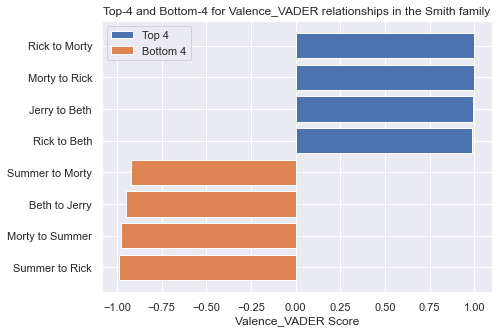

,count,mean,std,min,25%,50%,75%,max
Valence_VADER,19.0,0.346626,0.868709,-0.9865,-0.7468,0.7996,0.9813,0.9999


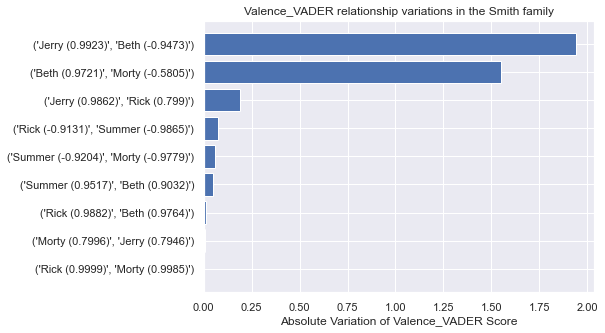

In [527]:
sentiment = 'Valence_VADER'
plot_top5_bottom5(sentiment, 4)
display(get_stats(sentiment))
plot_interactions_comparison(sentiment)

In [540]:
analyse_interactions_NRC('Morty','Summer')['VAD scores']

{'Valence': 0.5568863636363637,
 'Dominance': 0.49376515151515143,
 'Arousal': 0.4557045454545454}

In [539]:
analyse_interactions_NRC('Summer','Morty')['VAD scores']

{'Dominance': 0.5106428571428572,
 'Valence': 0.5019571428571428,
 'Arousal': 0.4944571428571427}

In [543]:
analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon = all_lexicons['Arousal']
print(analyzer.polarity_scores(get_text_of('Summer','Morty')))
print(analyzer.polarity_scores(get_text_of('Morty','Summer')))

{'neg': 0.249, 'neu': 0.525, 'pos': 0.226, 'compound': 0.7506}
{'neg': 0.418, 'neu': 0.392, 'pos': 0.19, 'compound': -0.9996}


In [545]:
get_text_of('Morty','Beth')

"I wasn't kissing a pillow, mom. I just I didn't get a lot of sleep last night. Maybe my dreams were just too loud or something. Dad, mom, come on. Rick just needed my help is all. I know how to vacuum Mom and Dad, Summer, I've been doing it for six months! I’m going to go find Mom and Dad. He bails on everybody! He bailed on Mom when she was a kid! He -- He bailed on tiny planet! And in case I never made this clear to you, Summer, he bailed on you. He left you to rot in a world that he ruined because he doesn't care! Because nobody's special to him, Summer, not even himself. So, if you really want your grandpa back, grab a shovel. The one that won't let you down is buried in your backyard! I think... no matter what we put on there, we die. he said it's the part of the Vindicators he values. That means nothing. He wants our last moment alive to be spent knowing how few fucks he gave. Everyone in the universe is a hero, Mom. Which is why we don't need jackets.  And I'm pretty sure we do

In [544]:
get_text_of('Morty','Summer')

'It\'s Summer! Aw, geez. I know how to vacuum Mom and Dad, Summer, I\'ve been doing it for six months! Uh, just to be clear, it was Summer\'s job to put the mattress under- Boom! In your face Summer! You really dropped the ball, man. Summer, you\'re freaking me out. I know things have changed a lot, and I know you miss Rick, but getting him back wouldn\'t make things better. And, you know, we\'re not doing so bad. He bails on everybody! He bailed on Mom when she was a kid! He -- He bailed on tiny planet! And in case I never made this clear to you, Summer, he bailed on you. He left you to rot in a world that he ruined because he doesn\'t care! Because nobody\'s special to him, Summer, not even himself. So, if you really want your grandpa back, grab a shovel. The one that won\'t let you down is buried in your backyard! What?! No, I\'m not right. I-I was using ghoulish overkill! Ghoulish overkill, Summer! Summer, nobody has to know about that. We could put it right back and pretend we nev

### For each character individually : irrelevant

In [40]:
# save as csv
df_family_individual_sentiment_scores.to_csv('family_individual_sentiment_scores.csv',index=False)

In [41]:
df_family_individual_sentiment_scores = pd.read_csv('family_individual_sentiment_scores.csv')

In [42]:
df_family_individual_sentiment_scores.head()

,Character,Nb_tokens,Arousal,Dominance,Valence,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust,Valence_VADER
0,Rick,23960,-1.0000,1.0000,1.0,-1.0000,-1.0000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0000
1,Morty,11236,-1.0000,1.0000,1.0,-1.0000,-1.0000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.9999
2,Beth,3738,-1.0000,1.0000,1.0,-0.9998,-1.0000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.9998
3,Jerry,5985,-1.0000,0.9999,1.0,-0.9997,-1.0000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0000
4,Summer,3705,-0.9999,0.9999,1.0,-0.9994,-0.9999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.9994


### Other metrics

In [548]:
# Other metrics
interactions_other_scores = []

for aSourceChar in family_list.keys():
    for aTargetChar in family_list.keys():
        results_perso = analyse_one_char_words(aSourceChar)
        nb_tokens_total = len(results_perso['tokens'])
        if aSourceChar != aTargetChar:
            results = analyse_interactions_NRC(aSourceChar,aTargetChar)
            nb_tokens = len(results['tokens'])
            if nb_tokens > 100 :
                nb_interrogations = results['lines'].count('?')
                nb_exclamations = results['lines'].count('!')
                nb_egocentric = results['lines'].lower().count('i')+results['lines'].lower().count('me')+results['lines'].lower().count('my')
                nb_you = results['lines'].lower().count('you')
                aRow = [aSourceChar, aTargetChar, nb_tokens, nb_tokens/nb_tokens_total, nb_interrogations/nb_tokens, nb_exclamations/nb_tokens, nb_egocentric/nb_tokens, nb_you/nb_tokens]
                interactions_other_scores.append(aRow)

# to dataframe
df_interactions_other_scores = pd.DataFrame(interactions_other_scores,columns=['Source','Target','Nb_tokens','Ratio', 'Interrogation','Exclamation','Egocentric','You'])

In [549]:
df_interactions_other_scores.sort_values('Egocentric',ascending=False)

,Source,Target,Nb_tokens,Ratio,Interrogation,Exclamation,Egocentric,You
18,Summer,Jerry,286,0.077193,0.013986,0.055944,0.349650,0.027972
14,Jerry,Beth,473,0.079031,0.016913,0.023256,0.334038,0.042283
4,Morty,Rick,4298,0.382520,0.033737,0.039321,0.333876,0.047697
12,Jerry,Rick,473,0.079031,0.029598,0.016913,0.321353,0.061311
7,Morty,Summer,619,0.055091,0.012924,0.035541,0.319871,0.051696
5,Morty,Beth,297,0.026433,0.013468,0.043771,0.319865,0.033670
8,Beth,Rick,482,0.128946,0.033195,0.018672,0.319502,0.047718
11,Beth,Summer,175,0.046816,0.017143,0.022857,0.314286,0.051429
3,Rick,Summer,627,0.026169,0.007974,0.030303,0.314195,0.036683
15,Summer,Rick,440,0.118758,0.031818,0.034091,0.304545,0.047727


In [557]:
# print concerned words
sentiment_focus = 'Dominance'
df_NRC_VAD[df_NRC_VAD.Word.isin(results['tokens'])].sort_values(sentiment_focus, ascending=False)[['Word',sentiment_focus]]

,Word,Dominance
7589,god,0.886
4082,creator,0.856
3452,complete,0.809
6743,first,0.788
4325,dad,0.786
...,...,...
10839,may,0.245
16473,sorry,0.212
11644,need,0.200
10434,lose,0.176


---

# Study Beth and Jerry marriage through seasons

In [550]:
def add_line_to_season(aRow):
    seasons_strings[aRow['season no.']] += aRow['line']

seasons_strings = {k:'' for k in range (1,6)}

for aSeason in range(1,6):
    df_season = df_transcripts[df_transcripts['season no.']==aSeason]
    _ = df_season.apply(add_line_to_season, axis=1)
    # Save your output for future use
    # f = codecs.open('transcripts/per_season/S0'+str(aSeason)+'.txt', "w+", "utf-8")
    # f.write(seasons_strings[aSeason])
    # f.close()

In [551]:
# create NLTK objects: Corpus and Text
corpus_root = 'transcripts/per_season'
all_files = [f for f in listdir(corpus_root) if isfile(join(corpus_root, f))]
seasonCorpus = PlaintextCorpusReader(corpus_root, all_files)
seasonText = nltk.Text(seasonCorpus.words())

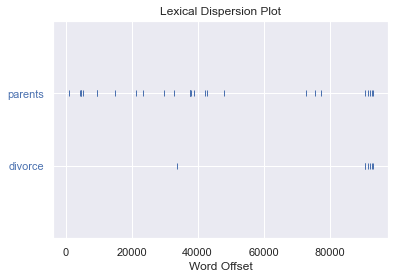

In [552]:
seasonText.dispersion_plot(["parents","divorce"])

In [553]:
seasonText.concordance('divorce')

Displaying 7 of 7 matches:
know , it has been lonely since the divorce . Some voids can ’ t be filled with
You know , I mean , I - I think the divorce is affecting her . And , you know ,
n , her parents are going through a divorce . Damn it , Rick , that ' s what I 
n properly deal with your parents ' divorce ! Alternatively , I have a freaking
z , I ' m so down with my parents ' divorce , dawg . Like , don ' t even trip ,
h . I got to deal with my parents ' divorce , and you got to , you know , do wh
w . My daughter ' s going through a divorce , and I am not dealing with it in a


In [555]:
seasonText.similar("divorce")

thing family universe rick a crazy guy world living lot hell scalpel
way floor man adventure second process fact system


In [ ]:
# get one document per season
season_documents = {aSeason:nltk.Text(seasonCorpus.words(['S0'+str(aSeason)+'.txt'])) for aSeason in seasons_strings.keys()}
season_documents

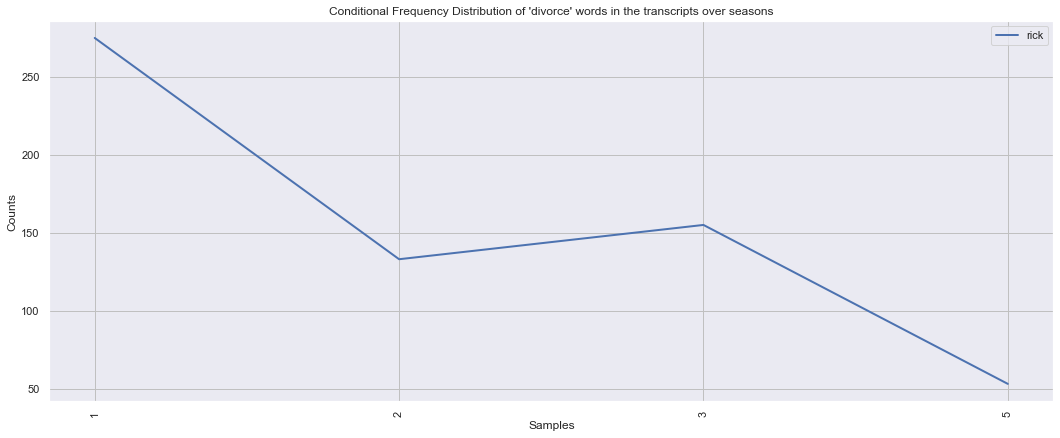

In [556]:
cfd_seasons = nltk.ConditionalFreqDist(
    (target, aSeason) 
    for aSeason in range(1,6)
    for w in seasonCorpus.words(['S0'+str(aSeason)+'.txt'])
    for target in ['rick']
    if w.lower().startswith(target)
)

plt.figure(figsize=(18,7))
plt.title("Conditional Frequency Distribution of 'divorce' words in the transcripts over seasons")
_ = cfd_seasons.plot()